# IMPORTS:

In [428]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from importlib import reload 
from art.attacks.evasion import AutoProjectedGradientDescent,ProjectedGradientDescent,AdversarialPatch,BasicIterativeMethod,CarliniL2Method,CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist
from sklearn.tree import DecisionTreeClassifier
from multi_MPD import UncertaintyTrainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from joblib import dump, load
import scipy
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model:

In [429]:
# Step 0: Define the neural network model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x

# MNIST DATASET:

In [430]:
# Step 1: Load the MNIST dataset

(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

# Step 1a: Swap axes to PyTorch's NCHW format

x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

# Model Creation:

In [431]:
# Step 2: Create the model

model = Net()

# Step 2a: Define the loss function and the optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Creating the ART Classifier:

In [432]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

# Training the Classifier:

In [433]:
# Step 4: Train the ART classifier

#classifier.fit(x_train, y_train, batch_size=64, nb_epochs=4)


In [434]:
#dump(classifier,'classifier.joblib')

### Since the model takes time to run from start, we store the model after it has been trained and then load it so that we dont need to train it for every run. 

In [435]:
classifier=load('classifier.joblib')

# Evaluating the Model's Performance:

In [436]:
# Step 5: Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 98.4%


# Generating AEs

#### NOTE: All the attacks were generated and stored seperately since it takes lot of time for generating the samples. We will be loading the samples directly for faster run.

In [437]:
class AEGenerator:
    def __init__(self, attack_name, x_test, y_test):

        self.attack_name = attack_name
        self.x_test = x_test
        self.y_test = y_test

        if attack_name == 'bim':
            self.attack = BasicIterativeMethod(classifier)
        elif attack_name == 'pgdlinf':
            self.attack = ProjectedGradientDescent(estimator=classifier,norm='inf')
        elif attack_name == 'pgdl1':
            self.attack = ProjectedGradientDescent(estimator=classifier,norm=1)
        elif attack_name == 'pgdl2':
            self.attack = ProjectedGradientDescent(estimator=classifier,norm=2,)
        elif attack_name == 'apgdlinf':
            self.attack = AutoProjectedGradientDescent(classifier, norm=np.inf)
        elif attack_name == 'apgdl1':
            self.attack = AutoProjectedGradientDescent(classifier, norm=1)
        elif attack_name == 'apgdl2':
            self.attack = AutoProjectedGradientDescent(classifier, norm=2)
        elif attack_name == 'cwl2':
            self.attack = CarliniL2Method(classifier,max_iter=50)
        elif attack_name == 'cwlinf':
            self.attack = CarliniLInfMethod(classifier,max_iter=50)

        # Generate adversarial examples
        self.x_test_adv = self.attack.generate(self.x_test)

        # Evaluate the ART classifier on the adversarial test examples
        self.adv_preds = classifier.predict(self.x_test_adv)

        # Getting the individual predictions and their indices
        self.ind_pred = np.argmax(self.adv_preds, axis=1) == np.argmax(self.y_test, axis=1)
        self.false_indices = np.where(~self.ind_pred)[0].tolist()

        # Calculating the accuracy
        self.acc_adv = np.sum(np.argmax(self.adv_preds, axis=1) == np.argmax(self.y_test, axis=1)) / len(self.y_test)
        print("Accuracy on {} adversarial test examples: {}%".format(self.attack_name.upper(), self.acc_adv * 100))
        print()
        print(f"The number of {self.attack_name.upper()} samples that successfully evaded the model are - {len(self.false_indices)}")

# BIM ATTACK:

In [438]:
# bim_attack = AEGenerator('bim',x_test,y_test)

In [439]:
#dump(bim_attack,'bim_attack.joblib')

In [440]:
#Loading the samples 
bim_attack=load('AttackSamples/bim_attack.joblib')

In [441]:
print("Accuracy on {} adversarial test examples: {}%".format(bim_attack.attack_name.upper(), bim_attack.acc_adv * 100))
print()
print(f"The number of {bim_attack.attack_name.upper()} samples that successfully evaded the model are - {len(bim_attack.false_indices)}")

Accuracy on BIM adversarial test examples: 1.17%

The number of BIM samples that successfully evaded the model are - 9883


# PGD ATTACK:

### PGD L INFINITY 

In [442]:
#pgdlinf_attack = AEGenerator('pgdlinf',x_test,y_test)

In [443]:
#dump(pgdlinf_attack,'AttackSamples/pgdlinf_attack.joblib')

In [444]:
#Loading the samples 
pgdlinf_attack=load('AttackSamples/pgdlinf_attack.joblib')

In [445]:
print("Accuracy on {} adversarial test examples: {}%".format(pgdlinf_attack.attack_name.upper(), pgdlinf_attack.acc_adv * 100))
print()
print(f"The number of {pgdlinf_attack.attack_name.upper()} samples that successfully evaded the model are - {len(pgdlinf_attack.false_indices)}")

Accuracy on PGDLINF adversarial test examples: 1.17%

The number of PGDLINF samples that successfully evaded the model are - 9883


### PGD L1

In [446]:
#pgdl1_attack = AEGenerator('pgdl1',x_test,y_test)

In [447]:
#dump(pgdl1_attack,'pgdl1_attack.joblib')

In [448]:
#Loading the samples 
pgdl1_attack=load('AttackSamples/pgdl1_attack.joblib')

In [449]:
print("Accuracy on {} adversarial test examples: {}%".format(pgdl1_attack.attack_name.upper(), pgdl1_attack.acc_adv * 100))
print()
print(f"The number of {pgdl1_attack.attack_name.upper()} samples that successfully evaded the model are - {len(pgdl1_attack.false_indices)}")

Accuracy on PGDL1 adversarial test examples: 98.41%

The number of PGDL1 samples that successfully evaded the model are - 159


### PGD L2

In [450]:
#pgdl2_attack = AEGenerator('pgdl2',x_test,y_test)

In [451]:
#dump(pgdl2_attack,'pgdl2_attack.joblib')

In [452]:
#Loading the samples 
pgdl2_attack=load('AttackSamples/pgdl2_attack.joblib')

In [453]:
print("Accuracy on {} adversarial test examples: {}%".format(pgdl2_attack.attack_name.upper(), pgdl2_attack.acc_adv * 100))
print()
print(f"The number of {pgdl2_attack.attack_name.upper()} samples that successfully evaded the model are - {len(pgdl2_attack.false_indices)}")

Accuracy on PGDL2 adversarial test examples: 92.89%

The number of PGDL2 samples that successfully evaded the model are - 711


# AUTO PGD ATTACK 

### AUTOPGD L INFINITY

In [454]:
#apgdlinf_attack = AEGenerator('apgdlinf',x_test,y_test)

In [455]:
#dump(apgdlinf_attack,'apgdlinf_attack.joblib')

In [456]:
#Loading the samples 
apgdlinf_attack=load('AttackSamples/apgdlinf_attack.joblib')

In [457]:
print("Accuracy on {} adversarial test examples: {}%".format(apgdlinf_attack.attack_name.upper(), apgdlinf_attack.acc_adv * 100))
print()
print(f"The number of {apgdlinf_attack.attack_name.upper()} samples that successfully evaded the model are - {len(apgdlinf_attack.false_indices)}")

Accuracy on APGDLINF adversarial test examples: 1.0%

The number of APGDLINF samples that successfully evaded the model are - 9900


### AUTOPGD L1

In [458]:
#apgdl1_attack = AEGenerator('apgdl1',x_test,y_test)

In [459]:
#dump(apgdl1_attack,'apgdl1_attack.joblib')

In [460]:
#Loading the samples 
apgdl1_attack=load('AttackSamples/apgdl1_attack.joblib')

In [461]:
print("Accuracy on {} adversarial test examples: {}%".format(apgdl1_attack.attack_name.upper(), apgdl1_attack.acc_adv * 100))
print()
print(f"The number of {apgdl1_attack.attack_name.upper()} samples that successfully evaded the model are - {len(apgdl1_attack.false_indices)}")

Accuracy on APGDL1 adversarial test examples: 98.4%

The number of APGDL1 samples that successfully evaded the model are - 160


### AUTOPGD L2

In [462]:
#apgdl2_attack = AEGenerator('apgdl2',x_test,y_test)

In [463]:
#dump(apgdl2_attack,'apgdl2_attack.joblib')

In [464]:
#Loading the samples 
apgdl2_attack=load('AttackSamples/apgdl2_attack.joblib')

In [465]:
print("Accuracy on {} adversarial test examples: {}%".format(apgdl2_attack.attack_name.upper(), apgdl2_attack.acc_adv * 100))
print()
print(f"The number of {apgdl2_attack.attack_name.upper()} samples that successfully evaded the model are - {len(apgdl2_attack.false_indices)}")

Accuracy on APGDL2 adversarial test examples: 98.4%

The number of APGDL2 samples that successfully evaded the model are - 160


# CW ATTACK

### CW L2 

In [466]:
#cwl2_attack = AEGenerator('cwl2',x_test,y_test)

In [467]:
#dump(cwl2_attack,'cwl2_attack.joblib')

In [468]:
#Loading the samples 
cwl2_attack=load('AttackSamples/cwl2_attack.joblib')

In [469]:
print("Accuracy on {} adversarial test examples: {}%".format(cwl2_attack.attack_name.upper(), cwl2_attack.acc_adv * 100))
print()
print(f"The number of {cwl2_attack.attack_name.upper()} samples that successfully evaded the model are - {len(cwl2_attack.false_indices)}")

Accuracy on CWL2 adversarial test examples: 9.93%

The number of CWL2 samples that successfully evaded the model are - 9007


### CW L INFINITY 

In [470]:
#cwlinf_attack = AEGenerator('cwlinf',x_test,y_test)

In [471]:
#dump(cwlinf_attack,'cwlinf_attack.joblib')

In [472]:
#Loading the samples 
cwlinf_attack=load('AttackSamples/cwlinf_attack.joblib')

In [473]:
print("Accuracy on {} adversarial test examples: {}%".format(cwlinf_attack.attack_name.upper(), cwlinf_attack.acc_adv * 100))
print()
print(f"The number of {cwlinf_attack.attack_name.upper()} samples that successfully evaded the model are - {len(cwlinf_attack.false_indices)}")

Accuracy on CWLINF adversarial test examples: 84.68%

The number of CWLINF samples that successfully evaded the model are - 1532


# Data Pre-processing for MPD

### Reshaping the Train and Test Set:

In [474]:
# Reshape the training and test data
x_train_mpd = x_train.reshape(x_train.shape[0], -1)
x_test_mpd = x_test.reshape(x_test.shape[0], -1)

# Extract labels using argmax
y_train_mpd = np.argmax(y_train, axis=1)
y_test_mpd = np.argmax(y_test, axis=1)


In [475]:
print(f"Shape of x train - {x_train_mpd.shape}")
print(f"Shape of y train - {y_train_mpd.shape}")
print(f"Shape of x test - {x_test_mpd.shape}")
print(f"Shape of y test - {y_test_mpd.shape}")

Shape of x train - (60000, 784)
Shape of y train - (60000,)
Shape of x test - (10000, 784)
Shape of y test - (10000,)


### Reshaping the Adversarial Samples:

In [476]:
x_test_bim=bim_attack.x_test_adv.reshape(bim_attack.x_test_adv.shape[0],-1)
x_test_pgdlinf=pgdlinf_attack.x_test_adv.reshape(pgdlinf_attack.x_test_adv.shape[0],-1)
x_test_apgdlinf=apgdlinf_attack.x_test_adv.reshape(apgdlinf_attack.x_test_adv.shape[0],-1)
x_test_cwl2=cwl2_attack.x_test_adv.reshape(apgdlinf_attack.x_test_adv.shape[0],-1)

In [477]:
print(f"Shape of BIM Samples - {x_test_bim.shape}")
print(f"Shape of PGD Samples - {x_test_pgdlinf.shape}")
print(f"Shape of AutoPGD Samples - {x_test_apgdlinf.shape}")
print(f"Shape of CW Samples - {x_test_cwl2.shape}")

Shape of BIM Samples - (10000, 784)
Shape of PGD Samples - (10000, 784)
Shape of AutoPGD Samples - (10000, 784)
Shape of CW Samples - (10000, 784)


# CLASS DISTRIBUTION

In [478]:
#Function for class distribution
def class_dist(labels):
    # get unique class labels and their counts
    unique_classes, class_counts= np.unique(labels, return_counts=True)

    # Print the class distribution
    for label, count in zip(unique_classes, class_counts):
        print(f"Class {label}: {count} samples")

## TRAIN SET: 

In [479]:
class_dist(y_train_mpd)

Class 0: 5923 samples
Class 1: 6742 samples
Class 2: 5958 samples
Class 3: 6131 samples
Class 4: 5842 samples
Class 5: 5421 samples
Class 6: 5918 samples
Class 7: 6265 samples
Class 8: 5851 samples
Class 9: 5949 samples


## TEST SET:

In [480]:
class_dist(y_test_mpd)

Class 0: 980 samples
Class 1: 1135 samples
Class 2: 1032 samples
Class 3: 1010 samples
Class 4: 982 samples
Class 5: 892 samples
Class 6: 958 samples
Class 7: 1028 samples
Class 8: 974 samples
Class 9: 1009 samples


# MPD

In [481]:
#Initialize the base clf
#base_clf=DecisionTreeClassifier()
#bootstrap_count=100
#mpd_detector= UncertaintyTrainer(x_train_mpd,y_train_mpd,base_clf,bootstrap_count)

In [482]:
#dump(mpd_detector,'mpd_trained.joblib')

In [483]:
#Loading the MPD Detector 
mpd_detector=load('mpd_trained.joblib')

### MPD SCORES FOR CLEAN DATA:

In [484]:
mpd_scores_normal=mpd_detector.get_mpd_score(x_test_mpd)

### MPD SCORES FOR AEs

In [485]:
mpd_scores_bim=mpd_detector.get_mpd_score(x_test_bim)

In [486]:
mpd_scores_pgd=mpd_detector.get_mpd_score(x_test_pgdlinf)

In [487]:
mpd_scores_apgd=mpd_detector.get_mpd_score(x_test_apgdlinf)

In [488]:
mpd_scores_cw=mpd_detector.get_mpd_score(x_test_cwl2)

In [489]:
atks = {
    'clean':mpd_scores_normal,
    'bim': mpd_scores_bim,
    'pgd': mpd_scores_pgd,
    'autopgd': mpd_scores_apgd,
    'cw': mpd_scores_cw
}

### Max Scores for all attacks:

In [490]:
max_mpd_scores = {}

def mpd_maxscores(atk_name, mpd_scores):
    max_value = round(mpd_scores.max(), 2)
    max_mpd_scores[atk_name] = max_value
    print(f"The max mpd score for {atk_name.upper()} = {max_value}")

In [491]:
for names in atks.keys():
    mpd_maxscores(names,atks[names])

The max mpd score for CLEAN = 0.91
The max mpd score for BIM = 0.93
The max mpd score for PGD = 0.93
The max mpd score for AUTOPGD = 0.93
The max mpd score for CW = 0.92


# Generating Graphs for MPD Scores Before & After Attack:

#### Graph Generation:
 
For clean samples pass - (*clean* , scores)

For perturbed samples pass - (attack name , scores)

Attack Names : 
* bim
* pgd
* autopgd
* cw


In [492]:
def mpd_score_graph(atk_name,mpd_scores):
    if atk_name=='clean':
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title("MPD scores before attack")
        plt.ylim(0,4000)
    else:
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title(f"MPD scores after {atk_name.upper()} attack")
        plt.ylim(0,4000)

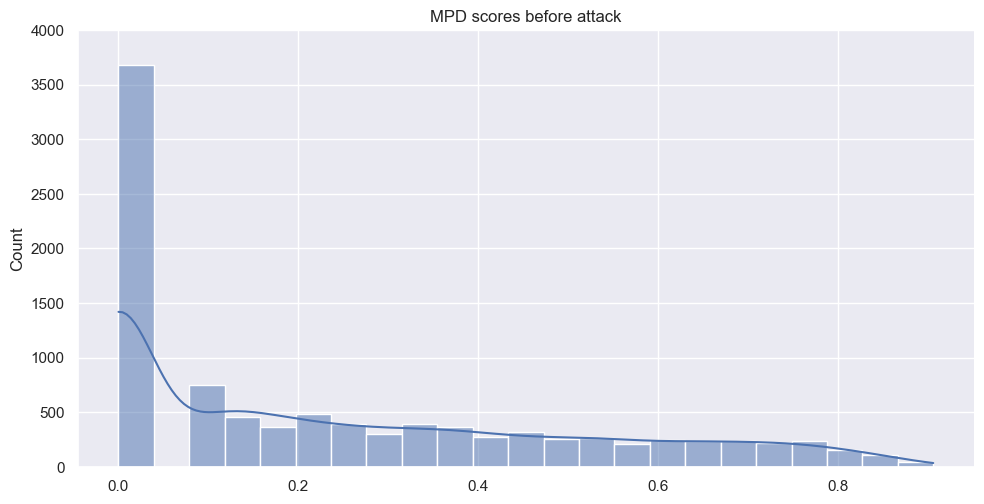

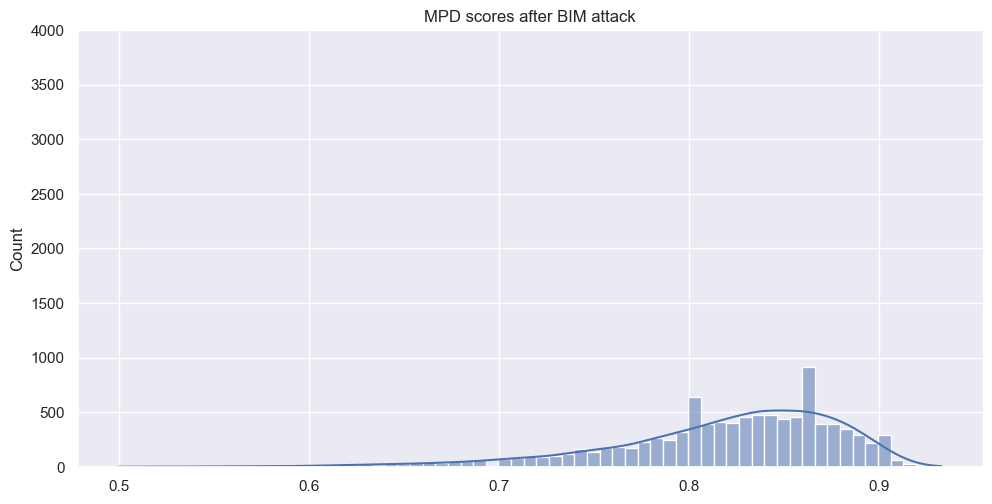

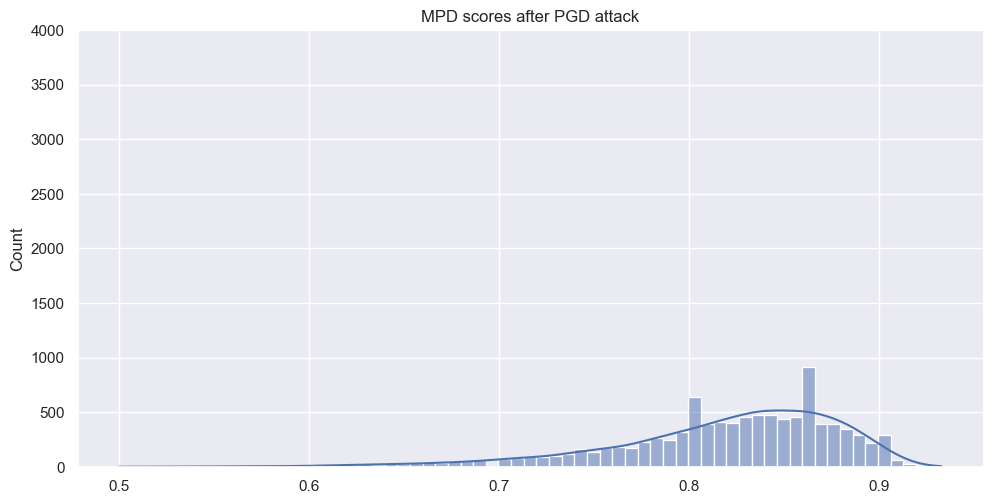

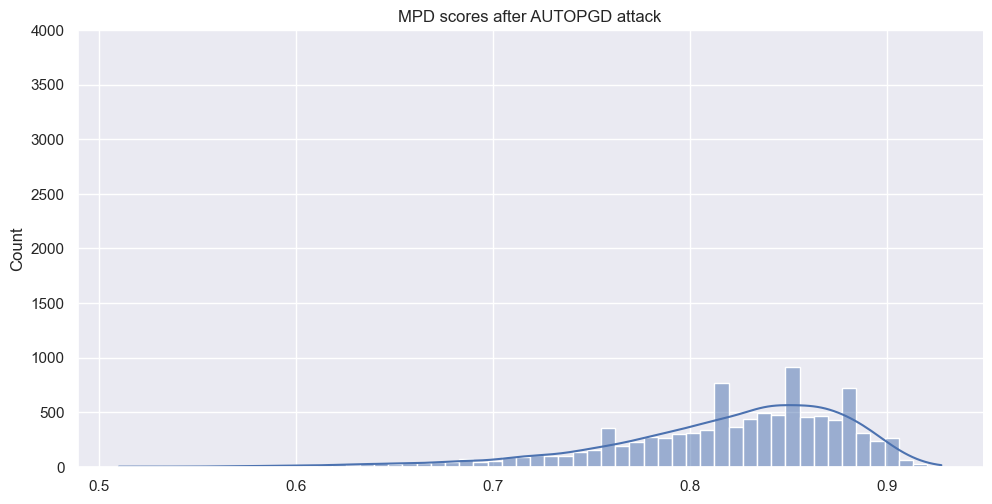

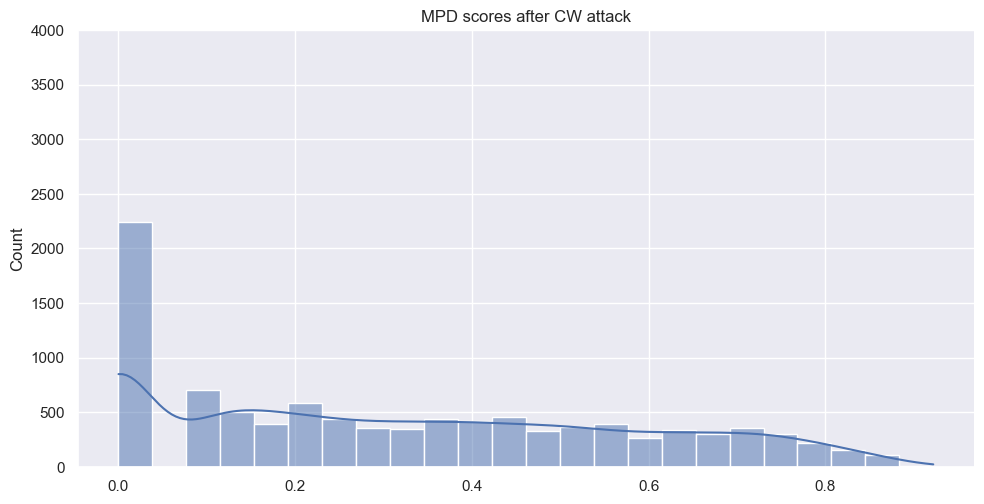

In [493]:
for names in atks.keys():
    mpd_score_graph(names,atks[names])

# ATTACK SAMPLES THAT WORK FOR ALL ATTACKS 

In [494]:
# Find common elements across all lists
common_indices = list(set(bim_attack.false_indices) & set(pgdlinf_attack.false_indices) & set(apgdlinf_attack.false_indices) & set(cwl2_attack.false_indices))
#print("Common Indices:", common_indices)
print("Common Samples found :", len(common_indices))

Common Samples found : 8987


### Creating AE Sets of common samples:

In [495]:
common_samples_bim=x_test_bim[common_indices]

In [496]:
common_samples_pgd=x_test_pgdlinf[common_indices]

In [497]:
common_samples_apgd=x_test_apgdlinf[common_indices]

In [498]:
common_samples_cw=x_test_cwl2[common_indices]

### Class Distribution of the Common Attack Set:

In [499]:
y_common_samples=y_test_mpd[common_indices]

In [500]:
class_dist(y_common_samples)

Class 0: 812 samples
Class 1: 1040 samples
Class 2: 850 samples
Class 3: 842 samples
Class 4: 933 samples
Class 5: 828 samples
Class 6: 872 samples
Class 7: 922 samples
Class 8: 922 samples
Class 9: 966 samples


# Creating a Testbed:

#### For getting the threshold value we create a TestBed of 75% clean samples and 25% Adversarial Samples.

### 75% Clean Data:

In [501]:
x_test_stratified_clean, _, y_test_stratified_clean, _ = train_test_split(x_test_mpd, y_test_mpd, test_size=0.25, stratify=y_test_mpd, random_state=333)

# Now, x_test_stratified and y_test_stratified contain 75% of the stratified test data
print("Shape of x_test_stratified:", x_test_stratified_clean.shape)
print("Shape of y_test_stratified:", y_test_stratified_clean.shape)

Shape of x_test_stratified: (7500, 784)
Shape of y_test_stratified: (7500,)


### Class Distribution of the Clean Data:

In [502]:
class_dist(y_test_stratified_clean)

Class 0: 735 samples
Class 1: 851 samples
Class 2: 774 samples
Class 3: 757 samples
Class 4: 737 samples
Class 5: 669 samples
Class 6: 719 samples
Class 7: 771 samples
Class 8: 730 samples
Class 9: 757 samples


# MPD THRESHOLD CALCULATON

In [503]:
class MPD_Threshold_Calculator:
    def __init__(self, attack_name, x_common_samples_adv, y_common_samples):
        
        self.attack_name = attack_name
        self.x_common_samples_adv = x_common_samples_adv
        self.y_common_samples = y_common_samples

        # Use train_test_split with stratify to create new variables with 25% stratified data
        self.x_test_stratified_adv, _, self.y_test_stratified_adv, _ = train_test_split(self.x_common_samples_adv, self.y_common_samples, test_size=0.72, stratify=self.y_common_samples, random_state=333)

        self.x_test_stratified_adv=self.x_test_stratified_adv[:2500]
        self.y_test_stratified_adv=self.y_test_stratified_adv[:2500]
        
        # Now, x_test_stratified_adv and y_test_stratified_adv contain 25% of the stratified data from x_common_samples and y_common_samples
        print()
        print()
        print("Shape of x_test_stratified_bim:", self.x_test_stratified_adv.shape)
        print("Shape of y_test_stratified_bim:", self.y_test_stratified_adv.shape)
        print()
        print()
        print(f"Class Distribution for {self.attack_name.upper()} :")
        class_dist(self.y_test_stratified_adv)
        print()
        print()
        # Vertically stack the arrays to create a single set
        self.x_adv_testbed = np.vstack([x_test_stratified_clean, self.x_test_stratified_adv])
        #convert the labels as a binary problem i.e - AE or not AE
        self.y_adv_testbed = np.concatenate([np.zeros_like(y_test_stratified_clean), np.ones_like(self.y_test_stratified_adv)])

        # Now, x_testbed and y_testbed contain the combined set
        print(f"Shape of x_adv_testbed for {self.attack_name.upper()}:", self.x_adv_testbed.shape)
        print("Shape of y_adv_testbed:", self.y_adv_testbed.shape)
        print()
        print()
        print(f"Class Distribution for {self.attack_name} :")
        class_dist(self.y_adv_testbed)
        
        self.thvalues= np.linspace(0.01, max_mpd_scores[self.attack_name],int(max_mpd_scores[self.attack_name]*100))
        
        #mpd scores on the Adversarial Testbed
        self.mpd_scores_adv_testbed = mpd_detector.get_mpd_score(self.x_adv_testbed)
        
        self.score_list=pd.DataFrame(columns=["Threshold_value","TP","FN","FP","TN", "recall", 'f1_score', 'accuracy'])

        for idx, t in enumerate(self.thvalues) :
            mpd_preds = (self.mpd_scores_adv_testbed>t).astype(int)

            cmvalues= (confusion_matrix(self.y_adv_testbed, mpd_preds).ravel()).tolist()
            values=[t.tolist(),]
            values.extend(cmvalues)
            values.append(recall_score(self.y_adv_testbed,mpd_preds))  
            values.append(f1_score(self.y_adv_testbed,mpd_preds))
            values.append(accuracy_score(self.y_adv_testbed,mpd_preds))

            self.score_list.loc[idx] = values
            
        print()
        print()
        #print(self.score_list)
        self.tvalue = self.score_list[self.score_list.f1_score==self.score_list.f1_score.max()]
        print()
        print()
        print(self.tvalue)
            
            #taking the best threshold value 
        self.best_t = self.tvalue.Threshold_value.values[0]
        self.mpd_pred = self.mpd_scores_adv_testbed.copy()
        self.mpd_pred[self.mpd_pred > self.best_t ] = 1
        self.mpd_pred[self.mpd_pred <= self.best_t] = 0
            
        print()
        print()
        print()
        print()
        self.c = ConfusionMatrixDisplay(confusion_matrix(self.y_adv_testbed,self.mpd_pred), display_labels=['Non-Adversarial','Adversarial'])
        fig, ax = plt.subplots(figsize=(10,6))
        plt.grid(False)
        self.c.plot(ax = ax, cmap='OrRd', xticks_rotation = 0,values_format='d')

# BIM ATTACK DETECTION:



Shape of x_test_stratified_bim: (2500, 784)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for BIM :
Class 0: 226 samples
Class 1: 289 samples
Class 2: 237 samples
Class 3: 234 samples
Class 4: 260 samples
Class 5: 230 samples
Class 6: 242 samples
Class 7: 256 samples
Class 8: 257 samples
Class 9: 269 samples


Shape of x_adv_testbed for BIM: (10000, 784)
Shape of y_adv_testbed: (10000,)


Class Distribution for bim :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FN     FP      TN  recall  f1_score  accuracy
71             0.72  6993.0  507.0  167.0  2333.0  0.9332  0.873783    0.9326






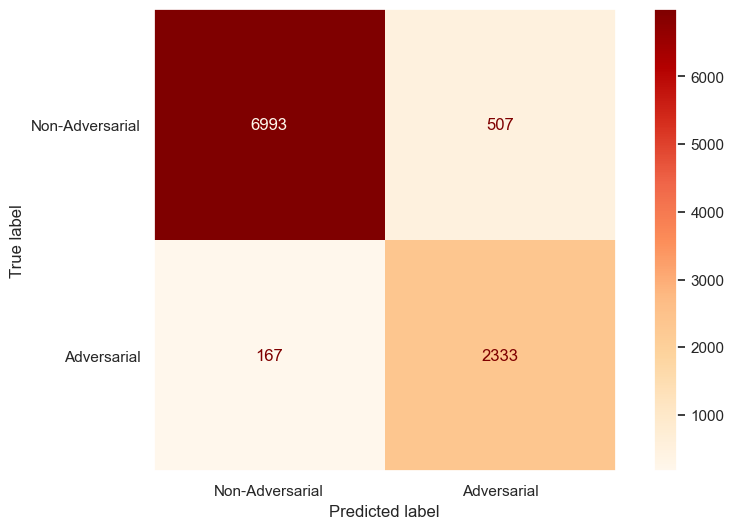

In [504]:
bim_t=MPD_Threshold_Calculator('bim',common_samples_bim,y_common_samples)

# PGD ATTACK DETECTION:



Shape of x_test_stratified_bim: (2500, 784)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for PGD :
Class 0: 226 samples
Class 1: 289 samples
Class 2: 237 samples
Class 3: 234 samples
Class 4: 260 samples
Class 5: 230 samples
Class 6: 242 samples
Class 7: 256 samples
Class 8: 257 samples
Class 9: 269 samples


Shape of x_adv_testbed for PGD: (10000, 784)
Shape of y_adv_testbed: (10000,)


Class Distribution for pgd :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FN     FP      TN  recall  f1_score  accuracy
71             0.72  6993.0  507.0  167.0  2333.0  0.9332  0.873783    0.9326






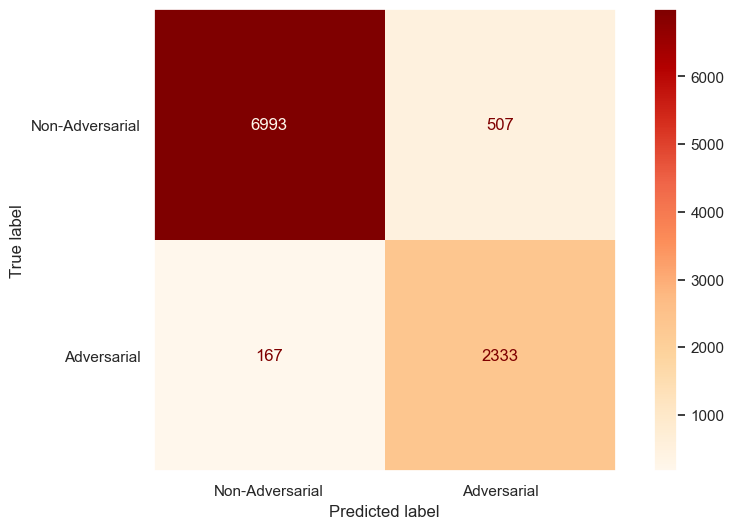

In [505]:
pgd_t=MPD_Threshold_Calculator('pgd',common_samples_pgd,y_common_samples)

# AUTOPGD ATTACK DETECTION:



Shape of x_test_stratified_bim: (2500, 784)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for AUTOPGD :
Class 0: 226 samples
Class 1: 289 samples
Class 2: 237 samples
Class 3: 234 samples
Class 4: 260 samples
Class 5: 230 samples
Class 6: 242 samples
Class 7: 256 samples
Class 8: 257 samples
Class 9: 269 samples


Shape of x_adv_testbed for AUTOPGD: (10000, 784)
Shape of y_adv_testbed: (10000,)


Class Distribution for autopgd :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FN     FP      TN  recall  f1_score  accuracy
73             0.74  7070.0  430.0  246.0  2254.0  0.9016  0.869599    0.9324






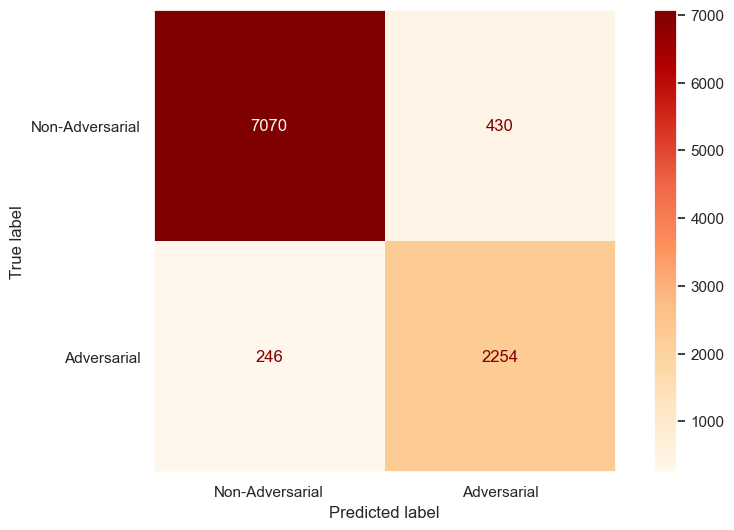

In [506]:
apgd_t=MPD_Threshold_Calculator('autopgd',common_samples_apgd,y_common_samples)

# CW ATTACK DETECTION:



Shape of x_test_stratified_bim: (2500, 784)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for CW :
Class 0: 226 samples
Class 1: 289 samples
Class 2: 237 samples
Class 3: 234 samples
Class 4: 260 samples
Class 5: 230 samples
Class 6: 242 samples
Class 7: 256 samples
Class 8: 257 samples
Class 9: 269 samples


Shape of x_adv_testbed for CW: (10000, 784)
Shape of y_adv_testbed: (10000,)


Class Distribution for cw :
Class 0: 7500 samples
Class 1: 2500 samples




   Threshold_value      TP      FN     FP      TN  recall  f1_score  accuracy
0             0.01  2760.0  4740.0  498.0  2002.0  0.8008   0.43324    0.4762
1             0.02  2760.0  4740.0  498.0  2002.0  0.8008   0.43324    0.4762
2             0.03  2760.0  4740.0  498.0  2002.0  0.8008   0.43324    0.4762
3             0.04  2760.0  4740.0  498.0  2002.0  0.8008   0.43324    0.4762
4             0.05  2760.0  4740.0  498.0  2002.0  0.8008   0.43324    0.4762
5             0.06  2760.0  4740.0  498.0  2002.0

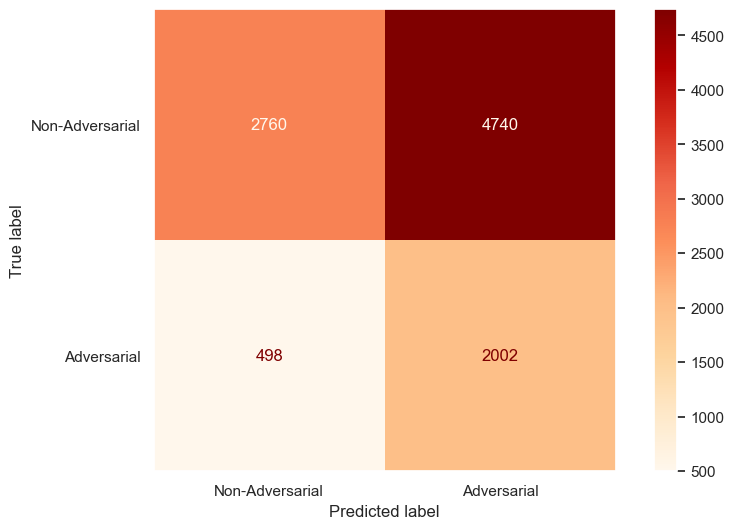

In [507]:
cw_t=MPD_Threshold_Calculator('cw',common_samples_cw,y_common_samples)